In [1]:
# Setup the library
import os
top_level=f'{os.getcwd()}/..'
import time
import math
import pyrogue as pr
import pyrogue.utilities.fileio
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Create a Virtual Client to connect to the Virtual Server via Zeromq
client = pr.interfaces.VirtualClient(addr='localhost', port=9099)

Connected to Root at localhost:9099


In [3]:
print ( '###################################################')
print ( '#             Firmware Version                    #')
print ( '###################################################')
print(client.Root.RFSoC.AxiSocCore.AxiVersion.PrintStatus())
print ( '###################################################')

###################################################
#             Firmware Version                    #
###################################################
Path         = Root.RFSoC.AxiSocCore.AxiVersion
FwVersion    = 0x2010100
UpTime       = 2:16:47
GitHash      = dirty (uncommitted code)
XilinxDnaId  = 0x4002000001602b051ca0e045
FwTarget     = SimpleRfSoc4x2Example
BuildEnv     = Vivado v2024.2
BuildServer  = rdsrv403 (Ubuntu 22.04.5 LTS)
BuildDate    = Mon Apr 21 12:05:50 PM PDT 2025
Builder      = ruckman
###################################################


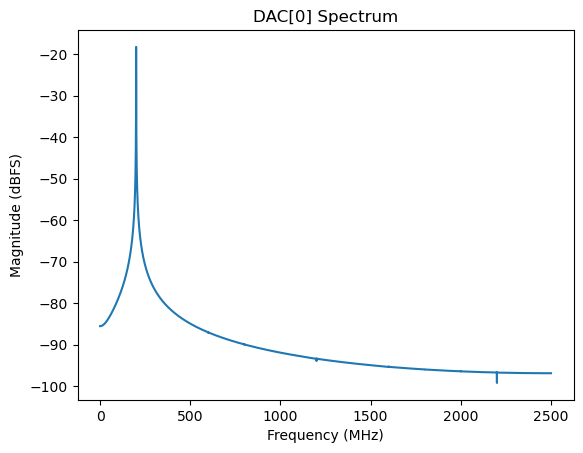

In [4]:
# Enable the processing of DAC waveforms on the PS CPU
FrameCount = client.Root.DacProcessor[0].FrameCount.get()
client.Root.DacProcessor[0].RxEnable.set(True)
while( (FrameCount+5) > client.Root.DacProcessor[0].FrameCount.get() ): time.sleep(0.1)
client.Root.DacProcessor[0].RxEnable.set(False)

# Plot the FFT
plt.title("DAC[0] Spectrum") 
plt.xlabel("Frequency (MHz)") 
plt.ylabel("Magnitude (dBFS)") 
plt.plot(client.Root.DacProcessor[0].Freq.value(), client.Root.DacProcessor[0].Magnitude.value())

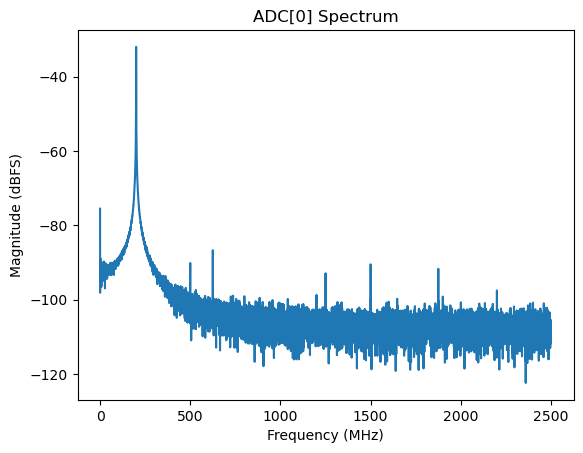

In [5]:
# Enable the processing of ADC waveforms on the PS CPU
FrameCount = client.Root.AdcProcessor[0].FrameCount.get()
client.Root.AdcProcessor[0].RxEnable.set(True)
while( (FrameCount+5) > client.Root.AdcProcessor[0].FrameCount.get() ): time.sleep(0.1)
client.Root.AdcProcessor[0].RxEnable.set(False)

# Plot the FFT
plt.title("ADC[0] Spectrum") 
plt.xlabel("Frequency (MHz)") 
plt.ylabel("Magnitude (dBFS)") 
plt.plot(client.Root.AdcProcessor[0].Freq.value(), client.Root.AdcProcessor[0].Magnitude.value())

In [6]:
print( 'Lets turn off all the continous streaming from ring buffers' )
for i in range(4):
    client.Root.RFSoC.Application.AppRingBuffer.Adc.Ch[i].ContinuousMode.set(0)
for i in range(2):
    client.Root.RFSoC.Application.AppRingBuffer.Dac.Ch[i].ContinuousMode.set(0)

Lets turn off all the continous streaming from ring buffers


In [7]:
for i in range(4):
    client.Root.RFSoC.Application.AppRingBuffer.Adc.Ch[i].ContinuousMode.set(0)
for i in range(2):
    client.Root.RFSoC.Application.AppRingBuffer.Dac.Ch[i].ContinuousMode.set(0)

print( 'Check trigger state ready for trigger mode' )
for i in range(4):
    while(client.Root.RFSoC.Application.AppRingBuffer.Adc.Ch[i].TrigState.get() != 0): 
        print( f'waiting on Adc.Ch[{i}]' )
        time.sleep(0.1)
for i in range(2):
    while(client.Root.RFSoC.Application.AppRingBuffer.Dac.Ch[i].TrigState.get() != 0): 
        print( f'waiting on Dac.Ch[{i}]' )
        time.sleep(0.1)

# This token sleep is to allow time for the software receive socket to clear out if there
# are any frames in flight after the Ring Buffers going to the software
time.sleep(1.0)

# Remove previous dataset
if os.path.isfile(f'{top_level}/test.dat'):
    os.remove(f'{top_level}/test.dat')    

# Useful pointer
dataWriter = client.Root.DataWriter

# Setup and open the file writer
print( f'file path: {top_level}/test.dat' )
dataWriter.DataFile.set(f'{top_level}/test.dat')
dataWriter.Open()
    
print( 'Trigger 10 waveform burst from DAC[0]' )
client.Root.RFSoC.Application.AppRingBuffer.Dac.Ch[0].TrigBurst.set(10)

print( 'Wait for the file write to write the 10 waveforms' )
while(dataWriter.FrameCount.get() < 10): time.sleep(0.1)

# Print the status
print( f'Number of frames received: {dataWriter.FrameCount.get()}' )
        
# Close the file writer
dataWriter.Close()

# Lets turn on all the continous streaming from ring buffers
for i in range(4):
    client.Root.RFSoC.Application.AppRingBuffer.Adc.Ch[i].ContinuousMode.set(1)
for i in range(2):
    client.Root.RFSoC.Application.AppRingBuffer.Dac.Ch[i].ContinuousMode.set(1)

Check trigger state ready for trigger mode
file path: /sdf/group/faders/users/ruckman/project/SimpleExamples/Simple-rfsoc-4x2-Example/software/notebooks/../test.dat
Trigger 10 waveform burst from DAC[0]
Wait for the file write to write the 10 waveforms
Number of frames received: 10


In [8]:
debug = False
with pyrogue.utilities.fileio.FileReader(files=f'{top_level}/test.dat') as fd:   
    
    # Loop through the file data
    for header,data in fd.records():

        if debug or (header.error>0):
            # Look at record header data
            print(f"Processing record. Total={fd.totCount}, Current={fd.currCount}")
            print(f"Record size    = {header.size}")
            print(f"Record channel = {header.channel}")
            print(f"Record flags   = {header.flags:#x}")
            print(f"Record error   = {header.error:#x}")

        # Check for polling variable data
        if header.channel == 64:
            # Convert the byte array into a string and remove end of line char at the end
            print(str(data, 'UTF-8').strip('\n'))

        # ADC Ring Buffer Path
        elif header.channel < 16:
            print( f'ADC[CH={header.channel}].size = {header.size} bytes')

        # DAC Ring Buffer Path
        elif header.channel < 32:
            print( f'DAC[CH={header.channel-16}].size = {header.size} bytes')

        else:
            print('UNDEFINED DATA STREAM!!!')

DAC[CH=0].size = 32768 bytes
DAC[CH=0].size = 32768 bytes
DAC[CH=0].size = 32768 bytes
DAC[CH=0].size = 32768 bytes
DAC[CH=0].size = 32768 bytes
DAC[CH=0].size = 32768 bytes
DAC[CH=0].size = 32768 bytes
DAC[CH=0].size = 32768 bytes
DAC[CH=0].size = 32768 bytes
DAC[CH=0].size = 32768 bytes


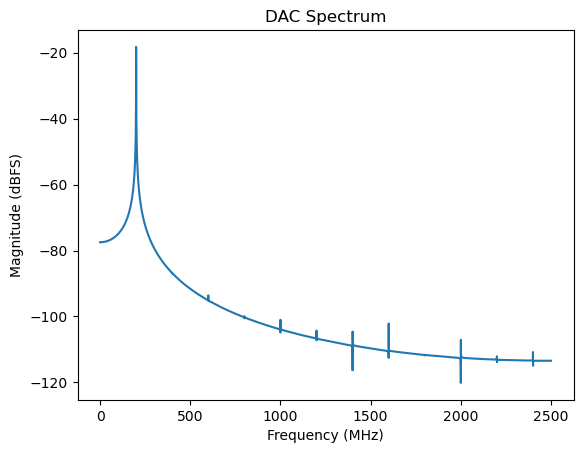

In [9]:
# Convert byte array into int16 array for last DAC waveform received
dacValue = data.view(np.int16)
wrdSize = len(dacValue)

# Calculate the FFT
freq = np.fft.fft(dacValue)/float(wrdSize)
freq = freq[range(wrdSize//2)]

# Calculate the magnitude
magnitude = 20.0*np.log10(np.abs(freq)/32767.0) # Units of dBFS

# Calculate the time/frequency x-axis arrays
timeBin  = 1.0E+9/5.0E+9 # Units of ns
freqBin  = (0.5E+3/timeBin)/float(wrdSize) # Units of MHz
timeSteps = np.linspace(0, timeBin*(wrdSize-1), num=wrdSize)
freqSteps = np.linspace(0, freqBin*(wrdSize-1), num=wrdSize//2)

# Plot the FFT
plt.title("DAC Spectrum") 
plt.xlabel("Frequency (MHz)") 
plt.ylabel("Magnitude (dBFS)") 
#plt.plot(timeSteps, dacValue)
plt.plot(freqSteps, magnitude)